# Visualize Sequence Embeddings with t-SNE

This notebook provides tools to visualize protein sequence embeddings using t-SNE (t-Distributed Stochastic Neighbor Embedding).

## Overview
The notebook includes:
1. A function to perform t-SNE on embeddings and color-code by metadata (e.g., Nextstrain clade)
2. Examples using S (spike) and N (nucleocapsid) protein embeddings
3. Multiple visualization options using different metadata columns
4. Tips for parameter tuning

## Inputs
- **Embeddings**: `.npy` files containing sequence embeddings (e.g., `s_sequence_embeddings.npy`)
- **IDs**: `.txt` files containing sequence IDs (e.g., `s_sequence_ids.txt`)
- **Metadata**: `all_sequences.csv` containing metadata like clades, lineages, regions, etc.

## Outputs
- Interactive t-SNE visualizations
- CSV files with t-SNE coordinates and metadata
- Optional: PNG files of the plots


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

Loading IDs from ../data/genomic_data/s_sequence_ids.txt...
Filtering out NODE (ancestral) sequences...
Sequences after NODE filter: 7904
Loading sequences metadata from ../data/genomic_data/all_sequences.csv...
Merging IDs with metadata...
Filtering to Massachusetts only...
Sequences after Massachusetts filter: 1487
Creating clade distribution histogram...


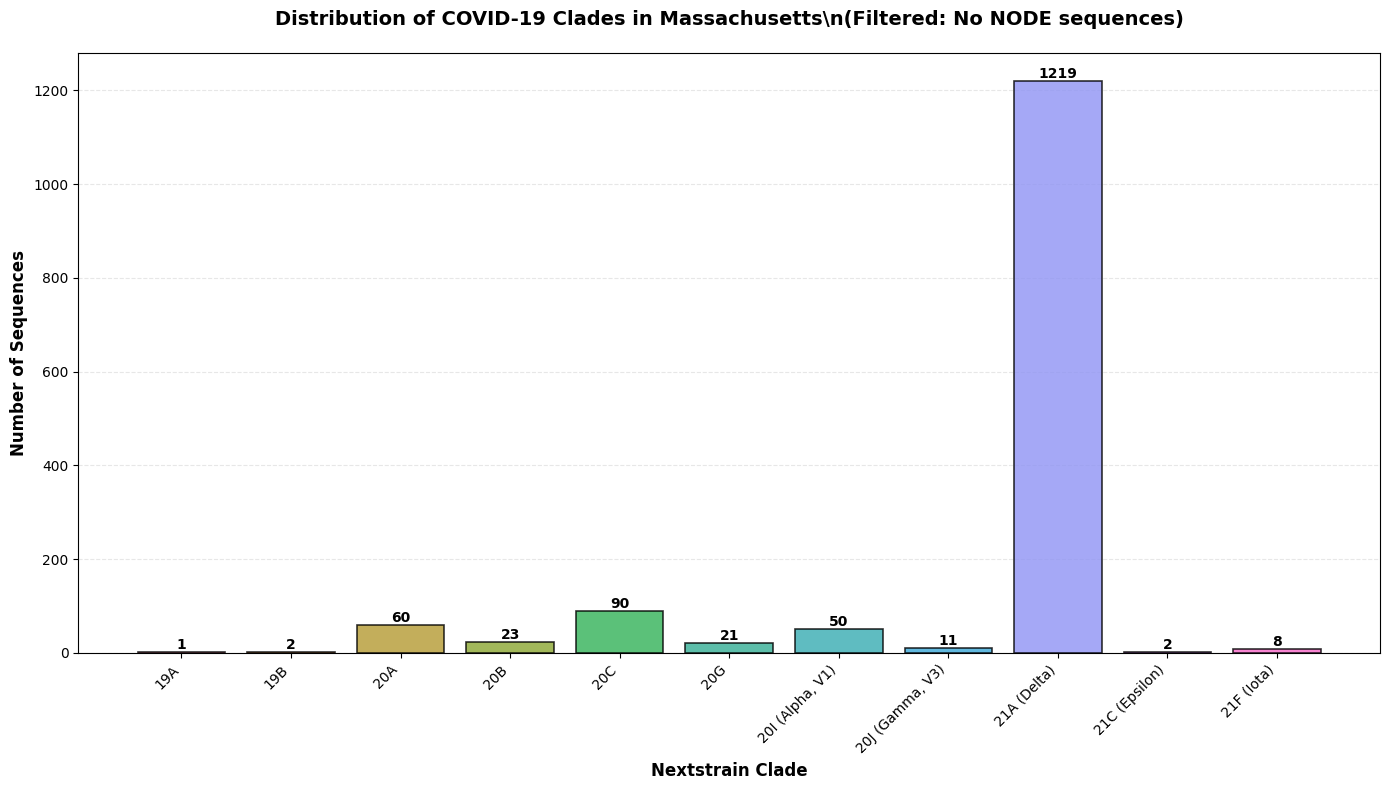


=== Clade Distribution Summary ===
Total sequences: 1487
Number of unique clades: 11

Clade counts:
  19A: 1 (0.1%)
  19B: 2 (0.1%)
  20A: 60 (4.0%)
  20B: 23 (1.5%)
  20C: 90 (6.1%)
  20G: 21 (1.4%)
  20I (Alpha, V1): 50 (3.4%)
  20J (Gamma, V3): 11 (0.7%)
  21A (Delta): 1219 (82.0%)
  21C (Epsilon): 2 (0.1%)
  21F (Iota): 8 (0.5%)


In [2]:
def plot_clade_distribution(ids_path, sequences_csv_path, figsize=(14, 8)):
    print(f"Loading IDs from {ids_path}...")
    with open(ids_path, "r") as f:
        ids = [line.strip() for line in f.readlines()]
    
    # Filter out IDs containing "NODE" (ancestral genomes)
    print("Filtering out NODE (ancestral) sequences...")
    mask = [("NODE" not in id_name) for id_name in ids]
    filtered_ids = [id_name for id_name in ids if "NODE" not in id_name]
    print(f"Sequences after NODE filter: {len(filtered_ids)}")
    
    # Load sequences CSV
    print(f"Loading sequences metadata from {sequences_csv_path}...")
    sequences_df = pd.read_csv(sequences_csv_path)
    
    # Create DataFrame with IDs
    ids_df = pd.DataFrame({"name": filtered_ids})
    
    # Merge with sequences metadata
    print("Merging IDs with metadata...")
    metadata_df = ids_df.merge(sequences_df, on="name", how="left")
    
    # Filter to only Massachusetts
    if "division_exposure" in metadata_df.columns:
        print("Filtering to Massachusetts only...")
        ma_mask = metadata_df["division_exposure"] == "Massachusetts"
        metadata_df = metadata_df[ma_mask].reset_index(drop=True)
        print(f"Sequences after Massachusetts filter: {len(metadata_df)}")
    
    # Fill missing clade information
    metadata_df["nextstrain_clade"] = metadata_df["nextstrain_clade"].fillna("Unknown")
    
    # Get clade counts
    clade_counts = metadata_df["nextstrain_clade"].value_counts().sort_index()
    
    # Create histogram
    print("Creating clade distribution histogram...")
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar plot
    bars = ax.bar(range(len(clade_counts)), clade_counts.values, 
                   color=sns.color_palette("husl", len(clade_counts)), 
                   edgecolor='black', linewidth=1.2, alpha=0.8)
    
    # Customize plot
    ax.set_xlabel("Nextstrain Clade", fontsize=12, fontweight='bold')
    ax.set_ylabel("Number of Sequences", fontsize=12, fontweight='bold')
    ax.set_title("Distribution of COVID-19 Clades in Massachusetts\\n(Filtered: No NODE sequences)", 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(range(len(clade_counts)))
    ax.set_xticklabels(clade_counts.index, rotation=45, ha='right')
    
    # Add value labels on top of bars
    for i, (bar, count) in enumerate(zip(bars, clade_counts.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Clade Distribution Summary ===")
    print(f"Total sequences: {len(metadata_df)}")
    print(f"Number of unique clades: {len(clade_counts)}")
    print(f"\nClade counts:")
    for clade, count in clade_counts.items():
        percentage = (count / len(metadata_df)) * 100
        print(f"  {clade}: {count} ({percentage:.1f}%)")
    
    return metadata_df

# Example usage with S sequence IDs
ids_path = '../data/genomic_data/s_sequence_ids.txt'
sequences_csv_path = '../data/genomic_data/all_sequences.csv'

filtered_metadata = plot_clade_distribution(ids_path, sequences_csv_path)


In [ ]:
def visualize_embeddings_tsne(
    embeddings_path,
    ids_path,
    sequences_csv_path,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    figsize=(14, 10),
    color_by="nextstrain_clade",
    save_path=None,
):
    """
    Perform t-SNE on embeddings and visualize with color coding based on metadata.

    embeddings_path : str or Path
        Path to the .npy file containing embeddings (e.g., s_sequence_embeddings.npy)
    ids_path : str or Path
        Path to the .txt file containing sequence IDs (e.g., s_sequence_ids.txt)
    sequences_csv_path : str or Path
        Path to the all_sequences.csv file with metadata
    perplexity : int, default=30
        t-SNE perplexity parameter (should be less than n_samples)
    n_iter : int, default=1000
        Number of iterations for t-SNE optimization
    random_state : int, default=42
        Random seed for reproducibility
    figsize : tuple, default=(14, 10)
        Figure size for the plot
    color_by : str, default='nextstrain_clade'
        Column name from sequences_csv to use for color coding

    Returns:
    --------
    tuple
        (tsne_results, metadata_df) - t-SNE coordinates and merged metadata DataFrame
    """

    # Load embeddings
    embeddings = np.load(embeddings_path)

    # Load IDs
    print(f"Loading IDs")
    with open(ids_path, "r") as f:
        ids = [line.strip() for line in f.readlines()]

    mask = [("NODE" not in id_name) for id_name in ids]
    filtered_ids = [id_name for id_name in ids if "NODE" not in id_name]
    filtered_embeddings = embeddings[mask]

    # Update embeddings to use filtered version
    embeddings = filtered_embeddings
    ids = filtered_ids

    # Load sequences CSV
    sequences_df = pd.read_csv(sequences_csv_path)
    print(f"Sequences CSV shape: {sequences_df.shape}")

    # Create DataFrame with IDs
    ids_df = pd.DataFrame({"name": ids})

    # Merge with sequences metadata
    print("Merging IDs with metadata...")
    metadata_df = ids_df.merge(sequences_df, on="name", how="left")
    print(f"Merged metadata shape: {metadata_df.shape}")

    # filter to only be MA
    if "division_exposure" in metadata_df.columns:
        ma_mask = metadata_df["division_exposure"] == "Massachusetts"
        metadata_df = metadata_df[ma_mask].reset_index(drop=True)
        embeddings = embeddings[ma_mask]

    # Check for missing metadata
    missing_metadata = metadata_df[color_by].isna().sum()
    if missing_metadata > 0:
        print(f"Warning: {missing_metadata} sequences missing {color_by} information")
        metadata_df[color_by] = metadata_df[color_by].fillna("Unknown")

    # Perform t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=n_iter,
        random_state=random_state,
        verbose=1,
    )
    tsne_results = tsne.fit_transform(embeddings)
    print("t-SNE complete!")

    # Add t-SNE coordinates to metadata
    metadata_df["tsne_1"] = tsne_results[:, 0]
    metadata_df["tsne_2"] = tsne_results[:, 1]

    # Create visualization
    _, ax = plt.subplots(figsize=figsize)

    # Get unique categories for color coding
    categories = metadata_df[color_by].unique()
    n_categories = len(categories)

    # Use a color palette
    if n_categories <= 10:
        palette = sns.color_palette("tab10", n_categories)
    elif n_categories <= 20:
        palette = sns.color_palette("tab20", n_categories)
    else:
        palette = sns.color_palette("husl", n_categories)

    # Plot each category
    for i, category in enumerate(sorted(categories)):
        mask = metadata_df[color_by] == category
        ax.scatter(
            metadata_df.loc[mask, "tsne_1"],
            metadata_df.loc[mask, "tsne_2"],
            c=[palette[i]],
            label=category,
            alpha=0.6,
            s=30,
            edgecolors="none",
        )

    # Customize plot
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.set_title(
        f"t-SNE Visualization of Sequence Embeddings\\nColored by {color_by}",
        fontsize=14,
        fontweight="bold",
    )

    # Legend
    if n_categories <= 20:
        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            frameon=True,
            fancybox=True,
            shadow=True,
        )
    else:
        print(f"Too many categories ({n_categories}) to show legend")

    ax.grid(True, alpha=0.3, linestyle="--")
    plt.tight_layout()

    plt.show()

    return tsne_results, metadata_df

## Visualize ORF1a Sequence Embeddings

Loading embeddings from ../data/genomic_data/orf1a_sequence_embeddings.npy...
Embeddings shape: (14761, 1280)
Loading IDs
Loading sequences metadata from ../data/genomic_data/all_sequences.csv...
Sequences CSV shape: (14761, 25)
Merging IDs with metadata...
Merged metadata shape: (7904, 25)
Performing t-SNE with perplexity=30, n_iter=1000...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1487 samples in 0.000s...
[t-SNE] Computed neighbors for 1487 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1487
[t-SNE] Computed conditional probabilities for sample 1487 / 1487
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.562439
[t-SNE] KL divergence after 1000 iterations: 0.324998
t-SNE complete!
Creating visualization...
Covid Variants: ['19A', '19B', '20B', '20J (Gamma, V3)', '20I (Alpha, V1)', '20A', '20C', '20G', '21C (Epsilon)', '21F (Iota)', '21A (Delta)']


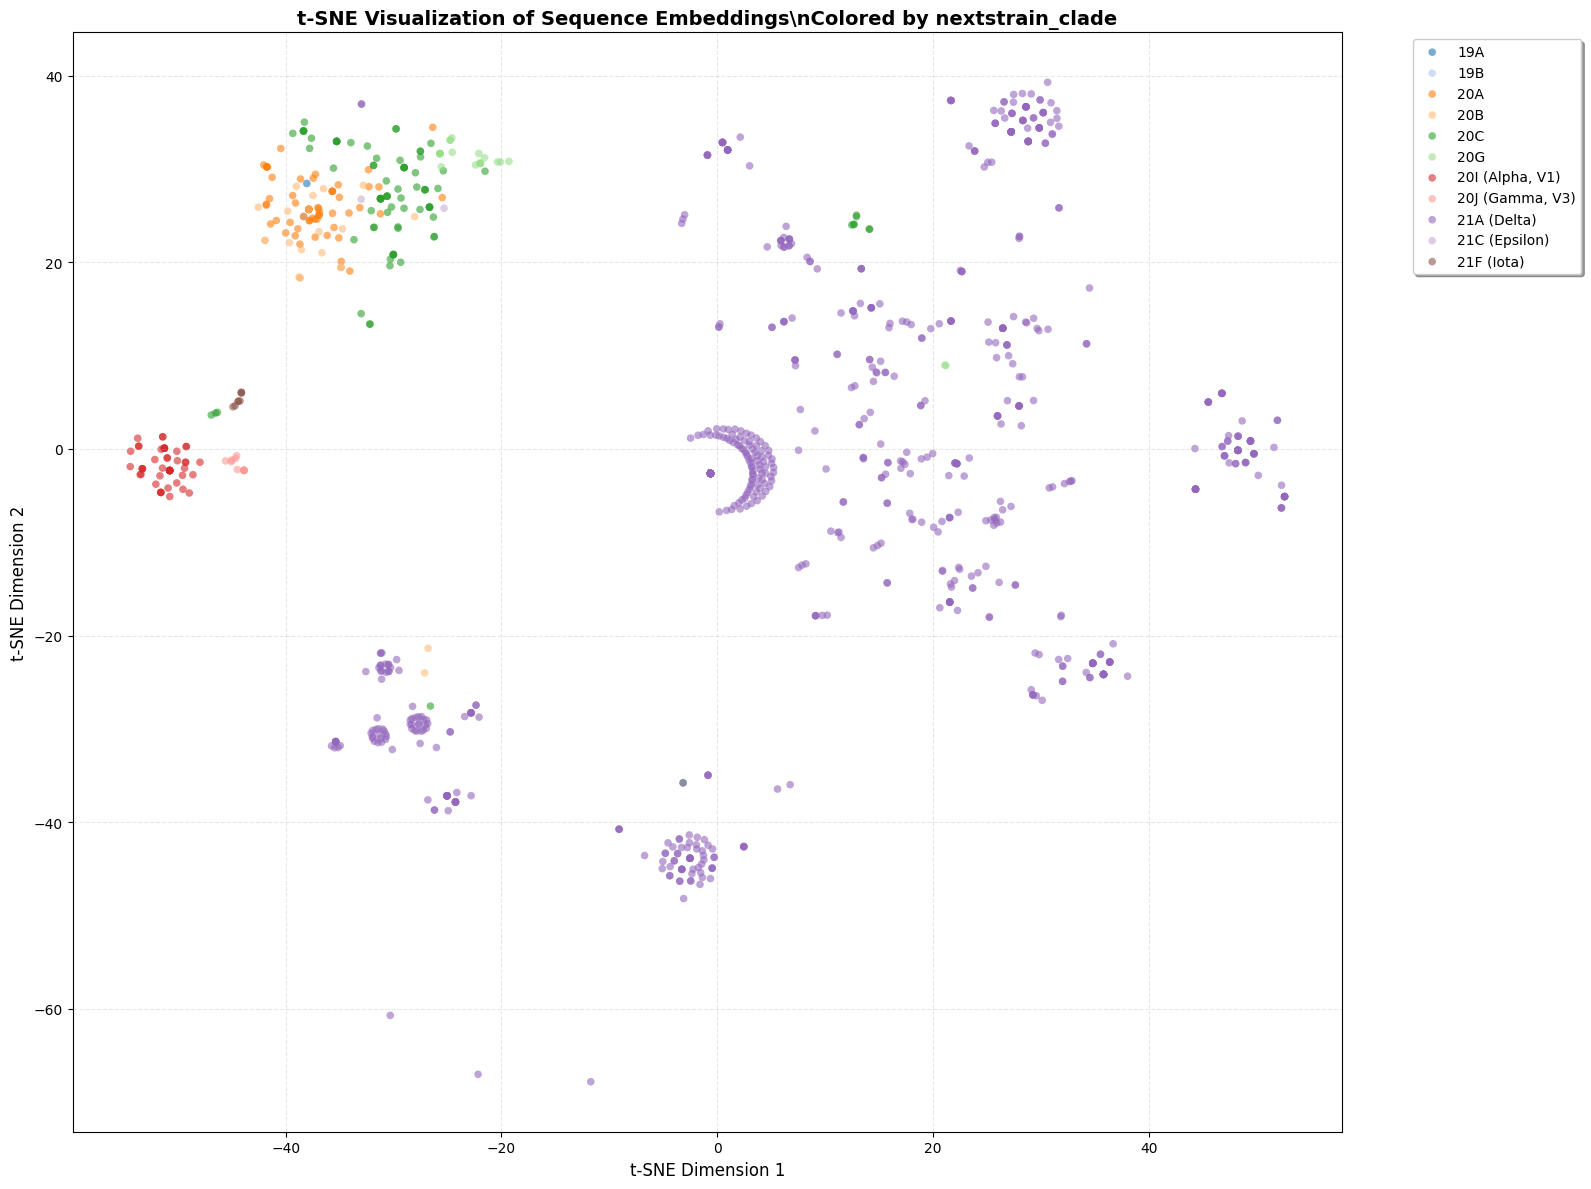


=== Summary ===
Total sequences: 1487

nextstrain_clade distribution:
nextstrain_clade
21A (Delta)        1219
20C                  90
20A                  60
20I (Alpha, V1)      50
20B                  23
20G                  21
20J (Gamma, V3)      11
21F (Iota)            8
19B                   2
21C (Epsilon)         2
19A                   1
Name: count, dtype: int64


In [ ]:
embeddings_path = '../data/genomic_data/orf1a_sequence_embeddings.npy'
ids_path = '../data/genomic_data/orf1a_sequence_ids.txt'
sequences_csv_path = '../data/genomic_data/all_sequences.csv'

# tSNE visualization
tsne_results, metadata_df = visualize_embeddings_tsne(
    embeddings_path=embeddings_path,
    ids_path=ids_path,
    sequences_csv_path=sequences_csv_path,
    perplexity=30,
    n_iter=1000,
    color_by='nextstrain_clade',
    figsize=(16, 12)
)